# Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tflearn, h5py, cv2, itertools
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('..')
from src.models.cnn_model import CNNModel

/home/cybercore/.virtualenvs/lungcancer/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cybercore/.virtualenvs/lungcancer/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cybercore/.virtualenvs/lungcancer/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cybercore/.virtualenvs/lu

Instructions for updating:
Colocations handled automatically by placer.


In [2]:
def get_metrics(Y_test_labels, label_predictions):
    cm = confusion_matrix(Y_test_labels[:,1], label_predictions[:,1])
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    precision = TP*1.0/(TP+FP)
    recall = TP*1.0/(TP+FN)
    specificity = TN*1.0/(TN+FP)
    return precision, recall, specificity, cm

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Build components

In [4]:
# Dataset

h5f = h5py.File('../src/data/train.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

print("X_train_images", X_train_images.shape)
print("Y_train_labels", Y_train_labels.shape)

X_train_images (5187, 50, 50, 1)
Y_train_labels (5187, 2)


In [5]:
# Model

convnet  = CNNModel()
network = convnet.define_network(
    X_train_images, Y_train_labels, num_outputs=2, hidden_embedding=512,
    use_pooling=True, use_bn=False, attention_ratio=1.0,
    use_triplet=False, triplet_hard_mining=False,
)
model = tflearn.DNN(network)

ckpt = tf.train.latest_checkpoint("../ckpt/attention1.0_softmax_bs8_ep200")
model.load(ckpt)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[CNNModel] Build model with attention_ratio: 1.0
[CNNModel] Build model with TripletLoss: False; HardMining: False
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/cybercore/thuync/LungCancerDetection/ckpt/attention1.0_softmax_bs8_ep200/nodule3-classifier.ckpt9591


# Get clusters

In [6]:
# Inference

preds = model.predict(X_train_images[:,:,:,:])
print("preds", preds.shape)

preds (5187, 2)


In [7]:
# Get clusters

pos_indicator = Y_train_labels[:,1]==1
neg_indicator = Y_train_labels[:,0]==1

pos_embeddings = preds[pos_indicator,:]
neg_embeddings = preds[neg_indicator,:]
print(pos_embeddings.shape, neg_embeddings.shape)

avg_pos_embedding = pos_embeddings.mean(axis=0)
avg_neg_embedding = neg_embeddings.mean(axis=0)
print("avg_pos_embedding", avg_pos_embedding)
print("avg_neg_embedding", avg_neg_embedding)

(845, 2) (4342, 2)
avg_pos_embedding [-3.0391402  3.0049295]
avg_neg_embedding [ 4.4390397 -4.148523 ]


# Testing

In [8]:
# Dataset

h5f2 = h5py.File('../src/data/test.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

print("X_test_images", X_test_images.shape)
print("Y_test_labels", Y_test_labels.shape)

X_test_images (1622, 50, 50, 1)
Y_test_labels (1622, 2)


In [9]:
# Inference

embeddings = model.predict(X_test_images[:,:,:,:])
print("embeddings", embeddings.shape)

embeddings (1622, 2)


In [10]:
# Cluster

pos_dists = ((embeddings-avg_pos_embedding)**2).sum(axis=1)[:,np.newaxis]
neg_dists = ((embeddings-avg_neg_embedding)**2).sum(axis=1)[:,np.newaxis]
dists = np.hstack([neg_dists, pos_dists])
pred_indicies = np.argmin(dists, axis=1)
neg_pred_indicies = np.argmax(dists, axis=1)

print("neg_ratio:", (pred_indicies==0).sum() / pred_indicies.size)
print("pos_ratio:", (pred_indicies==1).sum() / pred_indicies.size)

neg_ratio: 0.8113440197287299
pos_ratio: 0.18865598027127004


precision: 0.8300653594771242
recall: 0.900709219858156
specificity: 0.9611940298507463


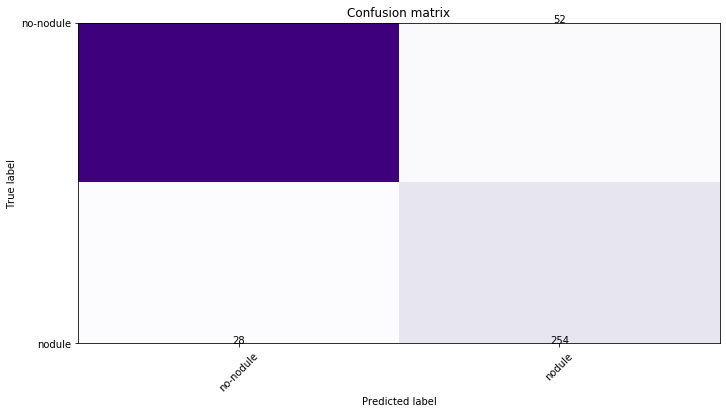

In [11]:
# Metrics

predictions = np.hstack([neg_pred_indicies[:,np.newaxis], pred_indicies[:,np.newaxis]])
precision, recall, specificity, cm = get_metrics(Y_test_labels, predictions)
print("precision:", precision)
print("recall:", recall)
print("specificity:", specificity)

plt.figure(figsize=(10,15))
plot_confusion_matrix(cm, classes=['no-nodule', 'nodule'], title='Confusion matrix')
plt.show()

# Visualize embeddings

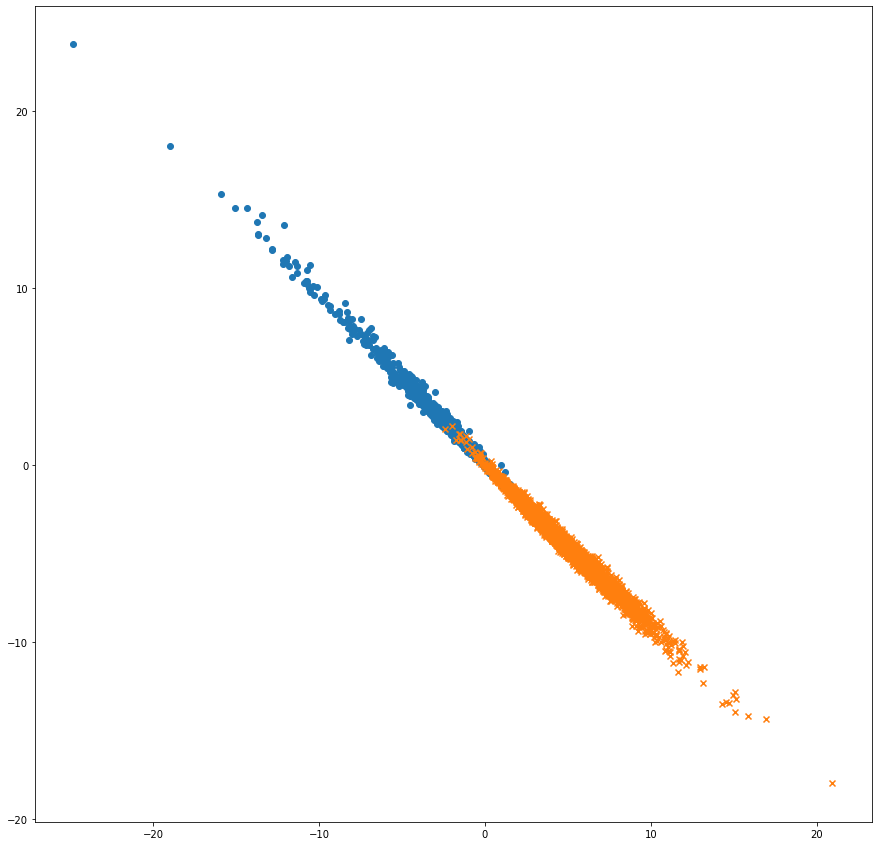

In [12]:
plt.figure(figsize=(15,15))
plt.scatter(pos_embeddings[:,0], pos_embeddings[:,1], marker='o')
plt.scatter(neg_embeddings[:,0], neg_embeddings[:,1], marker='x')
plt.show()